# Networks and Time: Latent Space Model Implementation

## Preliminaries

In [179]:
## libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import zipfile
import json
import pickle
import pycountry
import seaborn as sns
import math

from scipy.sparse.csgraph import laplacian
from scipy.linalg import eigh
from scipy.integrate import quad
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import ttest_ind
from sklearn.preprocessing import MinMaxScaler

### Trade 

In [117]:
## loading trade data in
zf = zipfile.ZipFile('/Users/teddyyankov/Library/CloudStorage/OneDrive-Nexus365/Data-Driven Network Science/conference/trade_network_data.csv.zip')
trade_df = pd.read_csv (zf.open('trade_network_data.csv'), index_col=0)
trade_df.drop(trade_df.columns[trade_df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [118]:
# Function to convert country name to ISO3 code
def get_iso3_code(country_name):
    try:
        country = pycountry.countries.get(name=country_name)
        return country.alpha_3
    except:
        return None

# Apply the function to convert location_name_1 to ISO3 code
trade_df['location_name_1'] = trade_df['location_name_1'].apply(get_iso3_code)

# Apply the function to convert location_name_2 to ISO3 code
trade_df['location_name_2'] = trade_df['location_name_2'].apply(get_iso3_code)

In [119]:
trade_df = trade_df.dropna(subset=['location_name_1', 'location_name_2'])

In [156]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Apply min-max normalization to the "edge_value" variable
trade_df['edge_value'] = scaler.fit_transform(trade_df[['edge_value']])

In [157]:
## creating graphs
trade_graphs = []

for i in sorted(trade_df['year'].unique()):

    edges = pd.DataFrame(
        {
            "source": list(trade_df['location_name_1']),
            "target": list(trade_df['location_name_2']),
            "weight": list(trade_df['edge_value'])
        }
    )
    
    G = nx.from_pandas_edgelist (edges, edge_attr = True)
    G.graph['year'] = int(i)

    # target_node = 'PAK'

    # # Get the one-hop neighbors of the target node
    # one_hop_neighbors = list(G.neighbors(target_node))
    # one_hop_neighbors.append(target_node)  # Adding the target node itself

    # # Create a subgraph with only the specified node and its one-hop neighbors
    # subgraph = G.subgraph(one_hop_neighbors)

    trade_graphs.append(G)

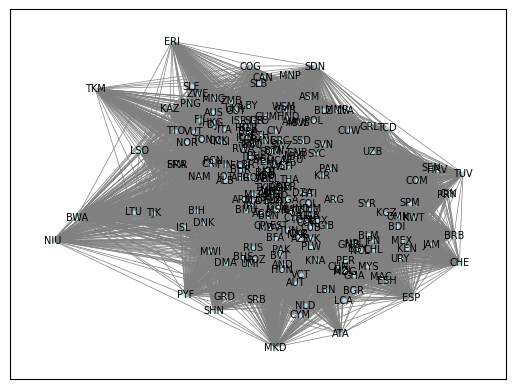

In [121]:
## drawing an example network
G = trade_graphs[2]
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx (G, pos, with_labels=True, node_size=5, node_color='lightblue', font_size=7, font_color='black', edge_color='gray', width=0.5)

In [17]:
# filtered_trade_graphs = []

# for graph in trade_graphs:
    
#     star_graph = nx.Graph()
#     star_graph.add_nodes_from (graph.nodes())
    
#     for neighbor in graph.neighbors("PAK"):
#         star_graph.add_edge("PAK", neighbor)
    
#     filtered_trade_graphs.append(star_graph)

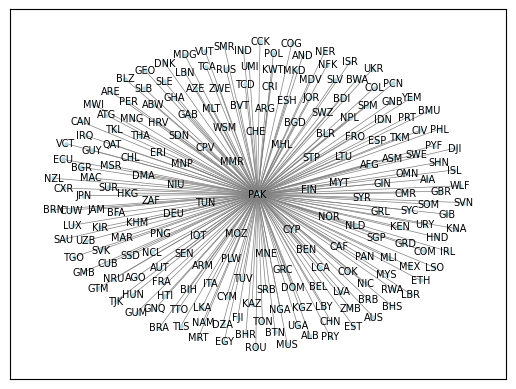

In [18]:
# ## drawing an example network
# G = filtered_trade_graphs[2]
# pos = nx.spring_layout(G, seed=42)
# nx.draw_networkx (G, pos, with_labels=True, node_size=5, node_color='lightblue', font_size=7, font_color='black', edge_color='gray', width=0.5)

In [19]:
# print (filtered_trade_graphs[2].nodes() == trade_graphs[2].nodes())

True


### Terrorism

In [158]:
# Load the ISO_pairs_terrorism2.csv file into a DataFrame
iso_pairs_df = pd.read_csv("/Users/teddyyankov/Library/CloudStorage/OneDrive-Nexus365/Data-Driven Network Science/conference/ISO_pairs_terrorism3.csv")

# Filter the years in ISO_pairs_terrorism2 to contain the same years as trade_df
filtered_iso_pairs_df = iso_pairs_df[iso_pairs_df['iyear'].isin(trade_df['year'])]
filtered_iso_pairs_df = filtered_iso_pairs_df [(filtered_iso_pairs_df['source'] != "IRN") | (filtered_iso_pairs_df['target'] != "IRN")]
# filtered_iso_pairs_df = filtered_iso_pairs_df [(filtered_iso_pairs_df['source'] == "PAK") | (filtered_iso_pairs_df['target'] == "PAK")]

In [159]:
filtered_iso_pairs_df.dropna(subset=['source'], inplace=True)

In [160]:
filtered_iso_pairs_df['count'] = scaler.fit_transform(filtered_iso_pairs_df[['count']])

In [162]:
# Create an empty graph
terrorism_graphs = []

# Iterate over each year in trade_df
for i in sorted(trade_df['year'].unique()):
    
    # Empty graph
    graph = nx.Graph()
    
    # index
    index = int(i)
    index = i - 2000
    index = int (index)
    
    # Get the graph corresponding to the year from trade_graphs
    year_graph = trade_graphs[index]
    
    # Add all the nodes from the year_graph to the graph
    graph.add_nodes_from (year_graph.nodes())
    
    # Get the pairs of nodes for the current year from filtered_iso_pairs_df
    year_pairs = filtered_iso_pairs_df [filtered_iso_pairs_df['iyear'] == i][['source', 'target', 'count']]
    
    # Add edges to the graph based on the pairs of nodes in year_pairs
    for _, row in year_pairs.iterrows():
        source = row['source']
        target = row['target']
        weight = row['count']
        if source in graph.nodes() and target in graph.nodes():
            graph.add_edge(source, target, weight = weight)
    
    # Remove nodes from graph that are not in year_graph
    # graph.remove_nodes_from(node for node in graph.nodes() if node not in year_graph.nodes())
    
    # adding graph 
    terrorism_graphs.append(graph)

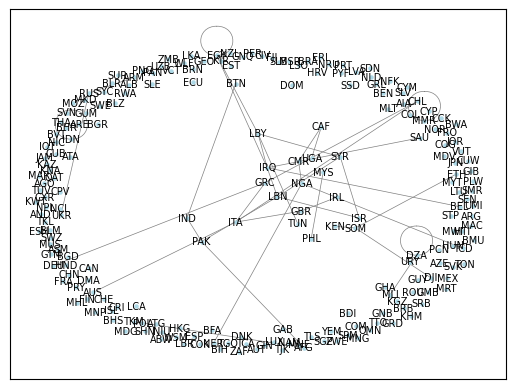

In [145]:
G = terrorism_graphs[14]
pos = nx.spring_layout(G, seed=41, k = .8)
nx.draw_networkx (G, pos, with_labels=True, node_size=5, node_color='lightblue', font_size=7, font_color='black', edge_color='gray', width=0.5)

In [163]:
print (trade_graphs[14].nodes() == terrorism_graphs[14].nodes())

True


### Migration

In [164]:
mig_df = pd.read_csv ("/Users/teddyyankov/Library/CloudStorage/OneDrive-Nexus365/Applied Analytical Statitics/Summative/dat_imputed.csv")
df_subset = pd.DataFrame (mig_df[['orig', 'dest', 'year', 'forced_mig']])
df_subset_filtered = df_subset[df_subset['year'].isin(trade_df['year'])]
df_subset_filtered['forced_mig'] = scaler.fit_transform(df_subset_filtered[['forced_mig']])
display (df_subset_filtered)

/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_55903/266053995.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_filtered['forced_mig'] = scaler.fit_transform(df_subset_filtered[['forced_mig']])


,orig,dest,year,forced_mig
83977,ESH,DZA,2000,0.044149
83978,COD,DZA,2000,0.000097
83979,UNK,DZA,2000,0.000016
83980,SDN,DZA,2000,0.000002
83981,SDN,DZA,2000,0.000002
...,...,...,...,...
176900,XXA,MNE,2021,0.000000
176901,BIH,MNE,2021,0.000001
176902,HRV,MNE,2021,0.000001
176903,COL,TTO,2021,0.000020


In [165]:
# Create an empty graph
mig_graphs = []

# Iterate over each year in trade_df
for i in sorted(trade_df['year'].unique()):
    
    # Empty graph
    graph = nx.Graph()
    
    # index
    index = int(i)
    index = i - 2000
    index = int (index)
    
    # Get the graph corresponding to the year from trade_graphs
    year_graph = trade_graphs[index]
    
    # Add all the nodes from the year_graph to the graph
    graph.add_nodes_from (year_graph.nodes())
    
    # Get the pairs of nodes for the current year from filtered_iso_pairs_df
    year_pairs = df_subset_filtered [df_subset_filtered['year'] == i][['orig', 'dest', 'forced_mig']]
    
    # Add edges to the graph based on the pairs of nodes in year_pairs
    for _, row in year_pairs.iterrows():
        source = row['orig']
        target = row['dest']
        weight = row['forced_mig']
        if source in graph.nodes() and target in graph.nodes():
            graph.add_edge(source, target, weight=weight)

    # Remove nodes from graph that are not in year_graph
    # graph.remove_nodes_from(node for node in graph.nodes() if node not in year_graph.nodes())

    # adding graph 
    mig_graphs.append(graph)

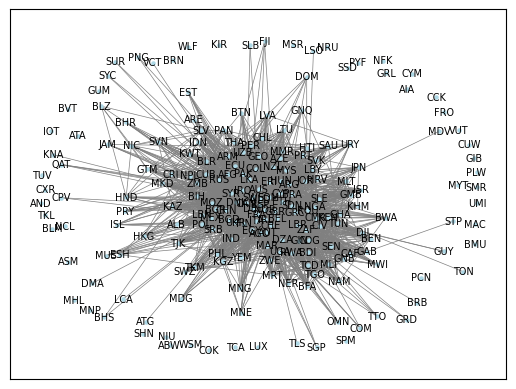

In [87]:
G = mig_graphs[14]
pos = nx.spring_layout(G, seed=41, k = .8)
nx.draw_networkx (G, pos, with_labels=True, node_size=5, node_color='lightblue', font_size=7, font_color='black', edge_color='gray', width=0.5)

In [129]:
print (mig_graphs[14].nodes() == terrorism_graphs[14].nodes())
print (mig_graphs[14].nodes() == trade_graphs[14].nodes())

True
True


## Distances

In [112]:
import pickle

# Save mig_graphs
with open('mig_graphs.pkl', 'wb') as f:
    pickle.dump(mig_graphs, f)

# Save trade_graphs
with open('trade_graphs.pkl', 'wb') as f:
    pickle.dump(trade_graphs, f)

# Save terrorism_graphs
with open('terrorism_graphs.pkl', 'wb') as f:
    pickle.dump(terrorism_graphs, f)

In [181]:
def spanning_tree_similarity(G1, G2):
    '''
    ## Parameters
    G1: Graph object at time t
    G2: Graph object at time t+n

    ## Return 
    Spanning tree similarity metric
    '''

    # create empty list of eigenvalues 
    eigens = []

    for G in [G1, G2]:
        L = nx.normalized_laplacian_matrix(G) # generate the Laplacian

        L_eigens = np.linalg.eigvals(L.toarray()) # obtain the eigenvalues of L

        L_eigens = L_eigens[L_eigens>0] # get eigenvalues that are larger than 0 

        eigens.append(sorted(L_eigens, reverse=False)) # sort from small to big 

    # calculate the product of eigen values
        
    ST_vals = []
    
    for eigen in eigens:
        prod = np.prod(eigen)

        ST = prod / len(eigen)

        ST_vals.append(ST)
    
    # calculate the difference between the two values 
    distance = np.abs(np.log(ST_vals[1]) - np.log(ST_vals[0]))

    return distance

In [147]:
## distance functions 
## creating weighted versions of my functions
# Jaccard
def weighted_jaccard_distance(G1, G2):
    
    '''
    Function to compute the weighted version of the Jaccard distance between two graphs
    using their adjacency matrices
    
    - Input: a pair of network graph objects
    - Output: Jaccard distance coefficient
    '''
    
    # getting adjacency matrices of the graphs
    A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight='weight').todense()
    A2 = nx.linalg.graphmatrix.adjacency_matrix (G2, weight='weight').todense()

    # computing numerator and denominator of the weighted Jaccard distance
    numerator = np.sum (np.abs (A1 - A2))
    denominator = np.sum (np.maximum (A1, A2))

    # computing the weighted Jaccard distance
    jaccard_distance = numerator / denominator
    return jaccard_distance

# IM
def weighted_ipsenMikhailov_distance (G1, G2, gamma = 0.1, limit = 100): 
    
    '''
    ADD DESCRIPTION
    '''
    from scipy.integrate import simps
    
    # weighted adjacency matrices
    A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight = 'weight').todense()
    A2 = nx.linalg.graphmatrix.adjacency_matrix (G2, weight = 'weight').todense()
    
    # baseline function for IM distances
    def IMdistance (A1, A2, gamma): 
            
        # number of nodes 
        n = len(A1)
            
        # Laplacians
        L1 = laplacian (A1, normed = False)
        L2 = laplacian (A2, normed = False)
            
        # ω: vibrational frequencies
        w1 = np.sqrt (np.abs (eigh (L1)[0][1:]))
        w2 = np.sqrt (np.abs (eigh (L2)[0][1:]))
            
        # normalisation constants K (l2 norm)
        norm1 = (n - 1) * np.pi / 2 - np.sum (np.arctan (-w1 / gamma))
        norm2 = (n - 1) * np.pi / 2 - np.sum (np.arctan (-w2 / gamma))
            
        # spectral densitites ρ(ω, γ)
        density1 = lambda w: np.sum (gamma / ((w - w1) ** 2 + gamma**2)) / norm1
        density2 = lambda w: np.sum (gamma / ((w - w2) ** 2 + gamma**2)) / norm2
            
        # IM distance
        func = lambda w: (density1(w) - density2(w)) ** 2
        return np.sqrt (quad (func, 0, np.inf, limit = limit)[0])

    # computing distance
    distance = IMdistance (A1, A2, gamma)
    return distance

# poly 
def weighted_polynomial_distance (G1, G2, k = 5, alpha = 1): 
    
    '''
    Function to compute the polynomial spectral distance between two graphs
    using their polynomial transformation of the eigenvalues of the
    of the adjacency matrix in combination with the eigenvectors of the
    adjacency matrix.
    
    - Input(s): 
            G1, G2 -> a pair of network graph objects
            k -> maximum degree of the polynomial used in 
                 the polynomial dissimilarity distance calculation
            alpha -> parameter controlling the influence of the 
                 polynomial transformation on the similarity score calculation
    - Output: Polynomial distance coefficient
    '''
    
    # getting adjacency matrices of the graphs
    A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight = 'weight').todense()
    A2 = nx.linalg.graphmatrix.adjacency_matrix (G2, weight = 'weight').todense()
    
    # similarity 
    def similarity(A, k, alpha): 
        
        # eigen-decomposition
        eigVals, eigVec = np.linalg.eig(A)
        
        # shape of adjMatrix -> number of nodes
        n = np.shape(A)[0]
        
        # defining polynomial
        def polynomial(degree):
            
            # replicating formula
            return eigVals**degree / (n - 1) ** (alpha * (degree - 1))
        
        # diagonal matrix constructed from the sum of the polynomial transformations
        W = np.diag (sum([polynomial(k) for k in range (1, k + 1)]))
        
        # similarity score matrix 
        similarityScore = np.dot (np.dot (eigVec, W), eigVec.T)
        return similarityScore
    
    # computing similarityScore for each adjMatrix
    simi_A1 = similarity(A1, k, alpha)
    simi_A2 = similarity(A2, k, alpha)
    
    # polynomial distance
    polyDist = np.linalg.norm (simi_A1 - simi_A2, ord = "fro") / A1.shape[0] ** 2
    
    return polyDist

In [166]:
## Jaccard mig and terror series
mig_ter_jaccard = []

for i in range(len(mig_graphs)):
    mig_graph = mig_graphs[i]
    terrorism_graph = terrorism_graphs[i]
    distance = weighted_jaccard_distance (mig_graph, terrorism_graph)
    mig_ter_jaccard.append(distance)

mig_ter_jaccard = pd.Series (mig_ter_jaccard)
print (mig_ter_jaccard)

0     0.996934
1     0.999563
2     0.996928
3     1.000000
4     1.000000
5     0.999650
6     1.000000
7     0.998113
8     0.998075
9     1.000000
10    0.998074
11    0.984704
12    0.978712
13    0.980895
14    0.975856
15    0.984762
16    0.983418
17    0.983478
18    0.984410
19    0.986804
20    0.985740
21    1.000000
dtype: float64


/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_55903/3930873011.py:15: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight='weight').todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_55903/3930873011.py:16: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix.adjacency_matrix (G2, weight='weight').todense()


In [167]:
## Jaccard trade and terror series
tra_ter_jaccard = []

for i in range(len(trade_graphs)):
    trade_graph = trade_graphs[i]
    terrorism_graph = terrorism_graphs[i]
    distance = weighted_jaccard_distance (trade_graph, terrorism_graph)
    tra_ter_jaccard.append(distance)

tra_ter_jaccard = pd.Series (tra_ter_jaccard)
print (tra_ter_jaccard)

/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_55903/3930873011.py:15: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight='weight').todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_55903/3930873011.py:16: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix.adjacency_matrix (G2, weight='weight').todense()


0     0.999900
1     0.999681
2     0.999959
3     0.999694
4     0.999613
5     0.999643
6     0.999965
7     0.999850
8     0.999071
9     0.999994
10    0.999992
11    0.999988
12    0.999039
13    0.998098
14    0.995107
15    0.998279
16    0.997496
17    0.998043
18    0.998538
19    0.995885
20    0.999365
21    1.000000
dtype: float64


In [168]:
## Jaccard mig and terror series
mig_ter_poly = []

for i in range(len(mig_graphs)):
    mig_graph = mig_graphs[i]
    terrorism_graph = terrorism_graphs[i]
    distance = weighted_polynomial_distance (mig_graph, terrorism_graph)
    mig_ter_poly.append(distance)

mig_ter_poly = pd.Series (mig_ter_poly)
print (mig_ter_poly)

/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_55903/3930873011.py:87: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight = 'weight').todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_55903/3930873011.py:88: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix.adjacency_matrix (G2, weight = 'weight').todense()


0     0.000030
1     0.000028
2     0.000025
3     0.000023
4     0.000023
5     0.000023
6     0.000020
7     0.000019
8     0.000018
9     0.000018
10    0.000016
11    0.000015
12    0.000014
13    0.000015
14    0.000026
15    0.000032
16    0.000032
17    0.000032
18    0.000044
19    0.000029
20    0.000030
21    0.000018
dtype: float64


In [175]:
## Jaccard mig and terror series
tra_ter_poly = []

for i in range(len(trade_graphs)):
    trade_graph = trade_graphs[i]
    terrorism_graph = terrorism_graphs[i]
    distance = weighted_polynomial_distance (trade_graph, terrorism_graph, k = 5, alpha = 1)
    tra_ter_poly.append(distance)

tra_ter_poly = pd.Series (tra_ter_poly)
print (tra_ter_poly)

/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_55903/3930873011.py:87: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A1 = nx.linalg.graphmatrix.adjacency_matrix (G1, weight = 'weight').todense()
/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_55903/3930873011.py:88: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A2 = nx.linalg.graphmatrix.adjacency_matrix (G2, weight = 'weight').todense()


0     0.000076
1     0.000076
2     0.000076
3     0.000076
4     0.000076
5     0.000076
6     0.000076
7     0.000076
8     0.000076
9     0.000076
10    0.000076
11    0.000076
12    0.000076
13    0.000076
14    0.000079
15    0.000081
16    0.000081
17    0.000081
18    0.000086
19    0.000079
20    0.000080
21    0.000076
dtype: float64


In [182]:
# spanning mig and terror
mig_ter_span = []

for i in range(len(mig_graphs)):
    mig_graph = mig_graphs[i]
    terrorism_graph = terrorism_graphs[i]
    distance = spanning_tree_similarity (mig_graph, terrorism_graph)
    mig_ter_span.append(distance)

mig_ter_span = pd.Series (mig_ter_span)
print (mig_ter_span)

0      50.241684
1      15.941416
2      15.441445
3      19.147073
4      18.645650
5      55.914077
6      59.027291
7      28.664606
8      27.155559
9      60.298222
10     29.641523
11     29.941804
12     31.403774
13      7.473891
14     44.684310
15     83.331265
16    155.064823
17    191.109172
18    191.034417
19    156.856394
20     50.299774
21           inf
dtype: float64


/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_55903/4252349693.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  ST = prod / len(eigen)


In [183]:
# spanning mig and terror
tra_ter_span = []

for i in range(len(mig_graphs)):
    trade_graph = trade_graphs[i]
    terrorism_graph = terrorism_graphs[i]
    distance = spanning_tree_similarity (trade_graph, terrorism_graph)
    tra_ter_span.append(distance)

tra_ter_span = pd.Series (tra_ter_span)
print (tra_ter_span)

<class 'networkx.utils.decorators.argmap'> compilation 16:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


0      42.493032
1      42.716176
2      42.310711
3      42.023028
4       4.082255
5      42.023028
6      42.310711
7      41.617563
8       4.921254
9      42.023028
10     42.310711
11     42.716176
12     39.959335
13      5.758283
14     71.759503
15     70.807889
16    141.110822
17    173.152790
18    175.509825
19    137.781855
20     67.007259
21           inf
dtype: float64


/var/folders/z6/nyjj_qlj0r7753xm0yqw3flw0000gn/T/ipykernel_55903/4252349693.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  ST = prod / len(eigen)
